In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
# from util import load_dataset, read_sensor_data_from_file
from resnet1d import ResNet1D, MyDataset
from acnn1d import ACNN, MyDataset
from crnn1d import CRNN, MyDataset
from net1d import Net1D, MyDataset

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def read_sensor_data_from_file(file_path):
    """
    读取txt文件中的数据，跳过第一行并只读取第2行到第127000行的数据（假设数据格式为127000*8）。
    """
    # data = pd.read_csv(file_path, delimiter=',',skiprows=1).values
    data = np.loadtxt(file_path)

    # if data.shape[0] < 126999 or data.shape[1] != 8:
    #     raise ValueError(f"File {file_path} has unexpected shape {data.shape}")

    # trimmed_data = data[0:126998, :]  # 从第2行到第127000行的数据

    # return trimmed_data
    return data

def load_dataset(data_folder):
    """
    从指定的文件夹加载数据集。数据文件在多层目录中，标签由文件夹名称确定。
    """
    all_X = []
    all_Y = []
    label_map = {'Eucalyptus': 0, 'Rosewood': 1, 'Sandalwood': 2}

    for subfolder_name in os.listdir(data_folder):
        subfolder_path = os.path.join(data_folder, subfolder_name)
        if not os.path.isdir(subfolder_path):
            continue
        
        if subfolder_name not in label_map:
            print(f"Unknown label folder: {subfolder_name}")
            continue
        
        label = label_map[subfolder_name]
        
        for root, dirs, files in os.walk(subfolder_path):
            for file in files:
                if file.endswith('.txt'):
                    file_path = os.path.join(root, file)
                    try:
                        data = read_sensor_data_from_file(file_path)
                        if data.shape == (1269, 8):# 126998
                            data = np.transpose(data, (1, 0))
                            all_X.append(data)
                            all_Y.append(label)
                        else:
                            print(f"File {file_path} has unexpected shape {data.shape}")
                    except ValueError as e:
                        print(e)

    all_X = np.array(all_X)
    all_Y = np.array(all_Y)
    return all_X, all_Y



In [2]:
data_folder = 'C:/Users/22209/Desktop/气体论文/Woodgass/Normal'
data, label = load_dataset(data_folder)
print(data.shape, Counter(label))


(2700, 8, 1269) Counter({0: 900, 1: 900, 2: 900})


In [3]:
# # Split data into train, validation, and test sets (8:1:1)
# data_train, data_temp, label_train, label_temp = train_test_split(data, label, test_size=0.2, random_state=42, stratify=label)
# data_val, data_test, label_val, label_test = train_test_split(data_temp, label_temp, test_size=0.5, random_state=42, stratify=label_temp)

# # Create datasets and dataloaders
# train_dataset = MyDataset(data_train, label_train)
# val_dataset = MyDataset(data_val, label_val)
# test_dataset = MyDataset(data_test, label_test)  

# 只划分训练和验证就是8；2
# split data into training and validation sets
data_train, data_val, label_train, label_val = train_test_split(data, label, test_size=0.2, random_state=42, stratify=label)

# create datasets and dataloaders
train_dataset = MyDataset(data_train, label_train)
val_dataset = MyDataset(data_val, label_val)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) # 只划分train和val的时候就不需要划分test了

In [9]:
# make model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# ----------------resnet------------------------
model = ResNet1D(
    in_channels=8, 
    base_filters=128,  #64
    kernel_size=9,  
    stride=2, 
    n_block=48, #34
    groups=8,
    n_classes=3, 
    downsample_gap=4, 
    increasefilter_gap=12, 
    verbose=False)
model.to(device)
summary(model, (data.shape[1], data.shape[2]))

#----------------ACNN(Attention)-----------------
# # make model
# device_str = "cuda"
# device = torch.device(device_str if torch.cuda.is_available() else "cpu")
# model = ACNN(
#     in_channels=8, 
#     out_channels=128, 
#     att_channels=16,
#     n_len_seg=32, 
#     verbose=True,
#     n_classes=3,
#     device=device)
# model.to(device)

# ## look model
# prog_iter = tqdm(train_dataloader, desc="init", leave=False)
# for batch_idx, batch in enumerate(prog_iter):
#     input_x, input_y = tuple(t.to(device) for t in batch)
#     pred = model(input_x)
#     break

#----------------DNN-----------------------------
# model = Net1D(
#     in_channels=1, 
#     base_filters=256, 
#     ratio=1.0, 
#     filter_mul_list=[1,2,2,4,4,8,8], 
#     m_blocks_list=[2,2,2,2,2,2,2], 
#     kernel_size=16, 
#     stride=2, 
#     groups=32,
#     verbose=True, 
#     n_classes=4)
# model.to(device)
# summary(model, (X_train.shape[1], X_train.shape[2]), device=device_str)
# exit()

#----------------TCNN(Transformer)-----------------
# device_str = "cuda"
# device = torch.device(device_str if torch.cuda.is_available() else "cpu")
# model = CRNN(
#     in_channels=1, 
#     out_channels=16, 
#     n_len_seg=50, 
#     verbose=False,
#     n_classes=2,
#     device=device)

# summary(model, torch.zeros(1, 1, 3000))

# model.to(device)

#----------------CRNN(LSTM)------------------------
# device_str = "cuda"
# device = torch.device(device_str if torch.cuda.is_available() else "cpu")
# model = CRNN(
#     in_channels=1, 
#     out_channels=16, 
#     n_len_seg=50, 
#     verbose=False,
#     n_classes=2,
#     device=device)

# summary(model, torch.zeros(1, 1, 3000))

# model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 128, 1269]           9,344
   MyConv1dPadSame-2            [-1, 128, 1269]               0
       BatchNorm1d-3            [-1, 128, 1269]             256
              ReLU-4            [-1, 128, 1269]               0
            Conv1d-5            [-1, 128, 1269]          18,560
   MyConv1dPadSame-6            [-1, 128, 1269]               0
       BatchNorm1d-7            [-1, 128, 1269]             256
              ReLU-8            [-1, 128, 1269]               0
           Dropout-9            [-1, 128, 1269]               0
           Conv1d-10            [-1, 128, 1269]          18,560
  MyConv1dPadSame-11            [-1, 128, 1269]               0
       BasicBlock-12            [-1, 128, 1269]               0
      BatchNorm1d-13            [-1, 128, 1269]             256
             ReLU-14            [-1, 12

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Initialize optimizer, loss function, and learning rate scheduler
# optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=10, verbose=True)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6, verbose=True)
loss_func = nn.CrossEntropyLoss()

# Initialize TensorBoard writer
writer = SummaryWriter(logdir='resnet1d/logs/resnet')

# Training loop with TensorBoard logging and model saving

# output_dir='./output/resnet'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
all_train_loss = []
all_val_loss = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    model.train()
    train_losses = []
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", leave=False):
        input_x, input_y = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        pred = model(input_x)
        loss = loss_func(pred, input_y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        train_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    all_train_loss.append(train_loss)
    writer.add_scalar('Loss/train', train_loss, epoch)

    # Validation
    model.eval()
    val_loss = 0
    all_pred_prob = []
    all_labels = []
    with torch.no_grad():
        for batch in val_dataloader:
            input_x, input_y = tuple(t.to(device) for t in batch)
            pred = model(input_x)
            loss = loss_func(pred, input_y)
            val_loss += loss.item()
            all_pred_prob.append(pred.cpu().data.numpy())
            all_labels.append(input_y.cpu().data.numpy())
    
    val_loss /= len(val_dataloader)
    all_val_loss.append(val_loss)
    writer.add_scalar('Loss/val', val_loss, epoch)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

    # Early stopping and saving the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter > 20:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Plotting
plt.plot(all_train_loss, label='Training Loss')
plt.plot(np.linspace(0, len(all_train_loss), len(all_val_loss)), all_val_loss, label='Validation Loss')
plt.legend()
plt.show()


Adjusting learning rate of group 0 to 1.0000e-02.


AssertionError: Input n_length should divided by n_len_seg

Accuracy: 0.8241
Precision: 0.8348
Recall: 0.8241
F1 Score: 0.8259
Confusion Matrix:
[[162  17   1]
 [ 10 150  20]
 [  1  46 133]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       180
           1       0.70      0.83      0.76       180
           2       0.86      0.74      0.80       180

    accuracy                           0.82       540
   macro avg       0.83      0.82      0.83       540
weighted avg       0.83      0.82      0.83       540



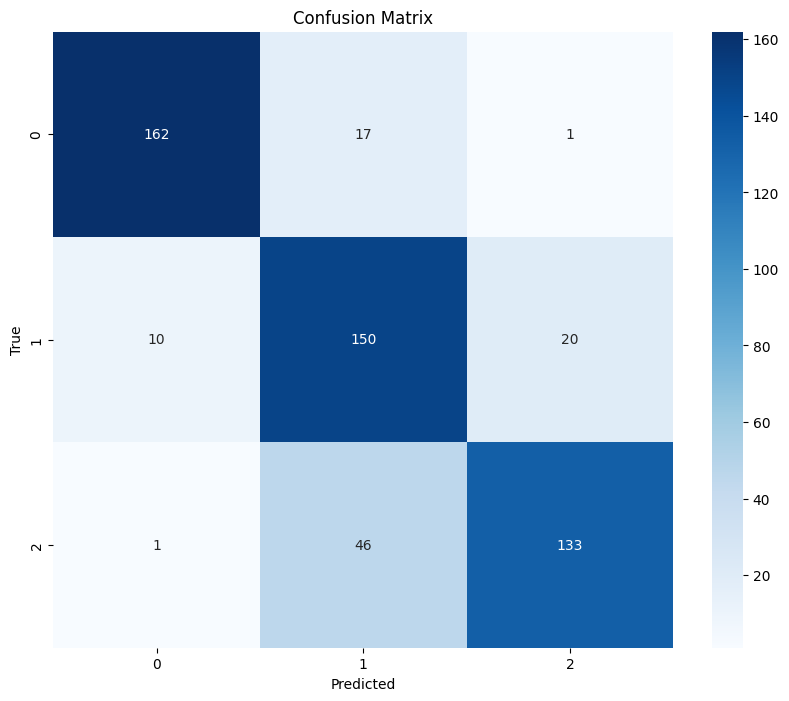

(0.8240740740740741,
 0.8347593002400461,
 0.8240740740740741,
 0.8258709965834825)

In [7]:
# Function to evaluate the model on the test set
def evaluate_model(model, dataloader, device):
    model.eval()
    all_pred_prob = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_x, input_y = tuple(t.to(device) for t in batch)
            pred = model(input_x)
            all_pred_prob.append(pred.cpu().data.numpy())
            all_labels.append(input_y.cpu().data.numpy())
    
    all_pred_prob = np.concatenate(all_pred_prob)
    all_labels = np.concatenate(all_labels)
    all_pred = np.argmax(all_pred_prob, axis=1)

    accuracy = accuracy_score(all_labels, all_pred)
    precision = precision_score(all_labels, all_pred, average='weighted')
    recall = recall_score(all_labels, all_pred, average='weighted')
    f1 = f1_score(all_labels, all_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification report
    report = classification_report(all_labels, all_pred)
    print("Classification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

# Load the best model and evaluate on the test set
# 如果想要使用验证集进行评估，原则上也只要把test换成val 应该就可以了
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, val_dataloader, device)